In [1]:
# All the imports required for this implementation
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.utils import spectral_norm
import torch.autograd as autograd

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

from torch.utils.data import TensorDataset, ConcatDataset, random_split, DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

from torchinfo import summary # Allows us to summarise the params and layers

from torch import nn, optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

from tqdm import tqdm
from PIL import Image
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import random
import argparse
import random
import os
import logging

In [2]:
# We can make use of a GPU if you have one on your computer. This works for Nvidia and M series GPU's
if torch.backends.mps.is_available():
    device = torch.device("mps")
    # These 2 lines assign some data on the memory of the device and output it. The output confirms
    # if we have set the intended device
    x = torch.ones(1, device=device)
    print (x)
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = ("cpu")
    x = torch.ones(1, device=device)
    print (x)

tensor([1.], device='cuda:0')


In [3]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_images(images, num_images=16, figsize=(10,10)):
    # Ensure the input is on CPU
    images = images.cpu().detach()
    
    # Normalize images from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    
    # Clamp values to [0, 1] range
    images = torch.clamp(images, 0, 1)
    
    # Make a grid of images
    grid = torchvision.utils.make_grid(images[:num_images], nrow=4)
    
    # Convert to numpy and transpose
    grid = grid.numpy().transpose((1, 2, 0))
    
    # Display the grid
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [4]:
# test this reshape vs traditional reshape
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args
    def forward(self, x):
        return x.view(self.shape)
    
class EqualLRLinear(nn.Module):
    def __init__(self, in_features, out_features, gain=np.sqrt(2)):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.gain = gain
        
        fan_in = in_features
        self.he_std = gain / np.sqrt(fan_in) # This aint mentioned in the paper lololol
        
        init_std = 1.0 / self.he_std
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * init_std)
        self.wscale = self.he_std
        
        self.bias = nn.Parameter(torch.zeros(out_features))
    
    def forward(self, x):
        # if input not flattened
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)
        
        weight = self.weight * self.wscale
        
        return F.linear(x, weight, self.bias)
    
    def __repr__(self):
        return (f'{self.__class__.__name__}({self.in_features}, {self.out_features}, '
                f'gain={self.gain})')

class EqualLRConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same', gain=np.sqrt(2)):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.gain = gain
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # ensure kernel_size is odd
        #assert kernel_size >= 1 and kernel_size % 2 == 1
        
        # fan_in
        fan_in = in_channels * kernel_size ** 2
        he_std = gain / np.sqrt(fan_in)
        
        init_std = 1.0 / he_std
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size) * init_std)
        self.wscale = he_std
        
        self.bias = nn.Parameter(torch.zeros(out_channels))
    
    def forward(self, x):
        weight = self.weight * self.wscale
        
        return F.conv2d(x, weight, self.bias, stride=self.stride, padding=self.padding)
    
    def __repr__(self):
        return (f'{self.__class__.__name__}({self.in_channels}, {self.out_channels}, '
                f'kernel_size={self.kernel_size}, stride={self.stride}, padding={self.padding}, '
                f'gain={self.gain})')

class EqualLRConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, gain=np.sqrt(2)):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.gain = gain
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.output_padding = output_padding
        
        # fan_in for transposed convolution is based on out_channels
        fan_in = out_channels * kernel_size ** 2
        he_std = gain / np.sqrt(fan_in)
        
        init_std = 1.0 / he_std
        self.weight = nn.Parameter(torch.randn(in_channels, out_channels, kernel_size, kernel_size) * init_std)
        self.wscale = he_std
        
        self.bias = nn.Parameter(torch.zeros(out_channels))
    
    def forward(self, x):
        weight = self.weight * self.wscale
        
        return F.conv_transpose2d(x, weight, self.bias, 
                                  stride=self.stride, 
                                  padding=self.padding, 
                                  output_padding=self.output_padding)
    
    def __repr__(self):
        return (f'{self.__class__.__name__}({self.in_channels}, {self.out_channels}, '
                f'kernel_size={self.kernel_size}, stride={self.stride}, '
                f'padding={self.padding}, output_padding={self.output_padding}, '
                f'gain={self.gain})')
    
    
class PixelNorm(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        # paper uses x / but we use x * here?!?!
        return x / torch.rsqrt(torch.mean(torch.square(x), dim=1, keepdim=True) + self.epsilon)
    
class MiniBatchStdDev(nn.Module):
    def __init__(self, group_size=4):
        super().__init__()
        self.group_size = group_size
    
    def forward(self, x):
        N, C, H, W = x.shape
        G = min(self.group_size, N)
        
        y = x.view(G, -1, C, H, W)
        
        y = y - torch.mean(y, dim=0, keepdim=True)
        y = torch.mean(torch.square(y), dim=0)
        y = torch.sqrt(y + 1e-8)
        y = torch.mean(y, dim=[1,2,3], keepdim=True)
        
        y = y.repeat(G, 1, H, W)
        
        return torch.cat([x,y], dim=1)

In [5]:
from math import sqrt

class EqualLR:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * sqrt(2 / (fan_in))

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module


class EqualLRConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        #nn.init.kaiming_normal_(conv.weight, mode='fan_out', nonlinearity='leaky_relu')
        #nn.init.constant_(conv.bias, 0)
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)


class EqualLRConvTranspose2d(nn.Module):
    ### additional module for OOGAN usage
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.ConvTranspose2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        #nn.init.kaiming_normal_(conv.weight, mode='fan_out', nonlinearity='leaky_relu')
        #nn.init.constant_(conv.bias, 0)
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)

class EqualLRLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()
        #nn.init.kaiming_normal_(linear.weight, mode='fan_in', nonlinearity='leaky_relu')
        #nn.init.constant_(linear.bias, 0)

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)
    
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        # paper uses x / but we use x * here?!?!
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True)
                                  + 1e-8)

class MiniBatchStdDev(nn.Module):
    def __init__(self, group_size=4):
        super().__init__()
        self.group_size = group_size
    
    def forward(self, x):
        N, C, H, W = x.shape
        G = min(self.group_size, N)
        
        y = x.view(G, -1, C, H, W)
        
        y = y - torch.mean(y, dim=0, keepdim=True)
        y = torch.mean(torch.square(y), dim=0)
        y = torch.sqrt(y + 1e-8)
        y = torch.mean(y, dim=[1,2,3], keepdim=True)
        
        y = y.repeat(G, 1, H, W)
        
        return torch.cat([x,y], dim=1)

In [6]:
class G_ConvBlock(nn.Module):
    def __init__(
        self, 
        in_c, 
        out_c, 
        ksize1, 
        padding,
        ksize2=None, 
        padding2=None,
        stride=None, 
        use_fc=False
    ):
        super().__init__()
        
        layers_list = []
        
        if ksize2 is None:
            ksize2 = ksize1
            
        if padding2 is None:
            padding2 = padding
        
        if use_fc:
            # Normalize input
            # layers_list.append(PixelNorm())
            
            # Fully connected layer for input
            #'''fc_out = out_c * 16
            #layers_list.extend([
            #    EqualLRLinear(in_features=512, out_features=fc_out, gain=np.sqrt(2)/4),
            #    Reshape(-1, out_c, 4, 4),
            #    nn.LeakyReLU(0.2),
            #    PixelNorm(),
            #])'''
            layers_list.extend([
                EqualLRConv2d(in_c, out_c, ksize1, padding=padding),
                PixelNorm(),
                nn.LeakyReLU(0.2),
                #PixelNorm(),
            ])
            # Conv 3x3 layer
            layers_list.extend([
                EqualLRConv2d(out_c, out_c, ksize2, padding=padding2),
                PixelNorm(),
                nn.LeakyReLU(0.2),
                #PixelNorm(),
            ])
        else:
            layers_list.extend([
                # Upscale
                nn.Upsample(scale_factor=2, mode='nearest'),
                EqualLRConv2d(in_c, out_c, ksize1, padding=padding),
                PixelNorm(),
                nn.LeakyReLU(0.2),
                #PixelNorm(),
                
                EqualLRConv2d(out_c, out_c, ksize2, padding=padding2),
                PixelNorm(),
                nn.LeakyReLU(0.2),
                #PixelNorm(),
            ])
        
        self.layers = nn.ModuleList(layers_list)
        
    def forward(self, x):
        for layer in self.layers:
            #print(layer)
            x = layer(x)
            #print(x.shape)
        return x
        #debug=True
        #for i, layer in enumerate(self.layers):
        #    x = layer(x)
        #    if debug:
        #        self.debug_output(x, f"Layer {i}: {type(layer).__name__}")
        #return x
    @staticmethod
    def debug_output(tensor, layer_name):
        if torch.isnan(tensor).any():
            print(f"NaN detected in {layer_name}")
            return

        print(f"\nDebugging {layer_name} output:")
        print(f"Shape: {tensor.shape}")
        print(f"Dtype: {tensor.dtype}")
        print(f"Device: {tensor.device}")

        try:
            stats = {
                "Min": tensor.min().item(),
                "Max": tensor.max().item(),
                "Mean": tensor.mean().item(),
                "Std": tensor.std().item()
            }
            print("\nParameter statistics:")
            for k, v in stats.items():
                print(f"{k}: {v:.6f}")

            print("Sample values:")
            print(tensor.view(-1)[:10])  # Print first 10 values

            if tensor.grad is not None:
                print("\nGradient statistics:")
                grad_stats = {
                    "Grad Min": tensor.grad.min().item(),
                    "Grad Max": tensor.grad.max().item(),
                    "Grad Mean": tensor.grad.mean().item(),
                    "Grad Std": tensor.grad.std().item()
                }
                for k, v in grad_stats.items():
                    print(f"{k}: {v:.6f}")
            else:
                print("\nNo gradient computed yet")

        except RuntimeError as e:
            print(f"Error computing statistics: {str(e)}")

        print("=" * 50)
            
class D_ConvBlock(nn.Module):
    def __init__(
        self,
        in_c,
        out_c,
        ksize1, 
        padding, 
        ksize2=None, 
        padding2=None,
        stride=None,   
        mbatch=None,
    ):
        super().__init__()
        
        layers_list = []
        
        if ksize2 is None:
            ksize2 = ksize1
        if padding2 is None:
            padding2 = padding
        
        if mbatch:
            layers_list.extend([
                MiniBatchStdDev(),
                EqualLRConv2d(in_c, out_c, ksize1, padding=padding),
                nn.LeakyReLU(0.2),
                EqualLRConv2d(out_c, out_c, ksize2, padding=padding2),
                nn.LeakyReLU(0.2),
                #nn.Flatten(),
                #EqualLRLinear(out_c*4*4, out_c),
                #nn.LeakyReLU(0.2),
                #EqualLRLinear(out_c, 1, gain=1),
            ])
        else:
            layers_list.extend([
                EqualLRConv2d(in_c, out_c, ksize1, padding=padding),
                nn.LeakyReLU(0.2),
                EqualLRConv2d(out_c, out_c, ksize2, padding=padding2),
                nn.LeakyReLU(0.2),
                #nn.AvgPool2d(2),
            ])
        
        self.layers = nn.ModuleList(layers_list)
    
    def forward(self, x):
        for layer in self.layers:
            #print(layer)
            x = layer(x)
            #print(x.shape)
        return x

In [7]:
# Credit to: https://github.com/odegeasslbc/Progressive-GAN-pytorch/blob/master/progan_modules.py#L161

class Generator(nn.Module):
    def __init__(self, in_c=128):
        super().__init__()
        
        self.in_c = in_c
        
        self.input_layer = nn.Sequential(
            EqualLRConvTranspose2d(in_c, in_c, 4, 1, 0),
            PixelNorm(),
            nn.LeakyReLU(0.2))
        
        self.block_4x4 = G_ConvBlock(in_c, in_c, 3, 1, use_fc=True)
        self.block_8x8 = G_ConvBlock(in_c, in_c, 3, 1)
        self.block_16x16 = G_ConvBlock(in_c, in_c, 3, 1)
        self.block_32x32 = G_ConvBlock(in_c, in_c, 3, 1)
        self.block_64x64 = G_ConvBlock(in_c, in_c//2, 3, 1)
        self.block_128x128 = G_ConvBlock(in_c//2, in_c//4, 3, 1)
        self.block_256x256 = G_ConvBlock(in_c//4, in_c//4, 3, 1)
        
        # no LeakyReLU on the to_RGBs
        self.to_rgb_4 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_8 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_16 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_32 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_64 = EqualLRConv2d(in_c//2, 3, 1)
        self.to_rgb_128 = EqualLRConv2d(in_c//4, 3, 1)
        self.to_rgb_256 = EqualLRConv2d(in_c//4, 3, 1)
                
        self.tanh = nn.Tanh()
    
    def debug_tensor(self, tensor, name):
        print(f"\nDebugging {name}:")
        print(f"Shape: {tensor.shape}")
        print(f"Dtype: {tensor.dtype}")
        print(f"Device: {tensor.device}")

        if torch.isnan(tensor).any():
            print("NaN detected")
        elif torch.isinf(tensor).any():
            print("Inf detected")

        try:
            print("\nParameter statistics:")
            print(f"Min: {tensor.min().item():.6f}")
            print(f"Max: {tensor.max().item():.6f}")
            print(f"Mean: {tensor.mean().item():.6f}")
            print(f"Std: {tensor.std().item():.6f}")
        except RuntimeError as e:
            print(f"Unable to compute statistics: {str(e)}")

        print("Sample values:")
        if tensor.numel() > 10:
            print(tensor.view(-1)[:10])
        else:
            print(tensor)

        if tensor.requires_grad:
            if tensor.grad is not None:
                print("\nGradient statistics:")
                grad = tensor.grad
                print(f"Grad shape: {grad.shape}")
                if torch.isnan(grad).any():
                    print("NaN detected in gradient")
                elif torch.isinf(grad).any():
                    print("Inf detected in gradient")
                try:
                    print(f"Grad min: {grad.min().item():.6f}")
                    print(f"Grad max: {grad.max().item():.6f}")
                    print(f"Grad mean: {grad.mean().item():.6f}")
                    print(f"Grad std: {grad.std().item():.6f}")
                    print("Grad sample:")
                    print(grad.view(-1)[:10])
                except RuntimeError as e:
                    print(f"Unable to compute gradient statistics: {str(e)}")
            else:
                print("No gradient computed yet")

        print("\n" + "="*50)

    def forward(self, x, layer_num, alpha):        
        #if torch.isnan(x).any():
        #    print("NaN in input X")
        #self.debug_tensor(x, "input")
        out_4 = self.input_layer(x.view(-1, self.in_c, 1, 1))
        #self.debug_tensor(out_4, "input_layer output")
        
        out_4 = self.block_4x4(out_4)
        #self.debug_tensor(out_4, "block_4x4 output")
        if layer_num == 1:
            out = self.to_rgb_4(out_4)
        #    self.debug_tensor(out, "to_rgb_4 output")
            out = self.tanh(out)
        #    self.debug_tensor(out, "final output (layer 1)")
            return out
        
        out_8 = self.block_8x8(out_4)
       # self.debug_tensor(out_8, "block_8x8 output")
        if layer_num == 2:
            # Pass out_4 through rgb4 and upscale it
            skip = self.to_rgb_4(out_4)
       #     self.debug_tensor(skip, "to_rgb_4 output")
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
       #     self.debug_tensor(skip, "interpolated skip")
            out = self.to_rgb_8(out_8)
       #     self.debug_tensor(out, "to_rgb_8 output")
            
            out = ((1-alpha) * skip) + (alpha * out)
       #     self.debug_tensor(out, "blended output")
            out = self.tanh(out)
       #     self.debug_tensor(out, "final output (layer 2)")
            return self.tanh(out)
        
        out_16 = self.block_16x16(out_8)
        #self.debug_tensor(out_16, "block_16x16 output")
        if layer_num == 3:
            skip = self.to_rgb_8(out_8)
        #    self.debug_tensor(skip, "to_rgb_8 output")
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
        #    self.debug_tensor(skip, "interpolated skip")
            out = self.to_rgb_16(out_16)
        #    self.debug_tensor(out, "to_rgb_16 output")
            
            out = ((1-alpha) * skip) + (alpha * out)
        #    self.debug_tensor(out, "blended output")
            out = self.tanh(out)
        #    self.debug_tensor(out, "final output (layer 3)")
            return out
        
        out_32 = self.block_32x32(out_16)
        #self.debug_tensor(out_16, "block_32x32 output")
        if layer_num == 4:
            skip = self.to_rgb_16(out_16)
        #    self.debug_tensor(skip, "to_rgb_16 output")
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
        #    self.debug_tensor(skip, "interpolated skip")
            out = self.to_rgb_32(out_32)
        #    self.debug_tensor(out, "to_rgb_32 output")
            
            out = ((1-alpha) * skip) + (alpha * out)
        #    self.debug_tensor(out, "blended output")
            out = self.tanh(out)
        #    self.debug_tensor(out, "final output (layer 4)")
            return out
        
        out_64 = self.block_64x64(out_32)
        if layer_num == 5:
            skip = self.to_rgb_32(out_32)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_64(out_64)
            
            out = ((1-alpha) * skip) + (alpha * out)
            return self.tanh(out)
        
        out_128 = self.block_128x128(out_64)
        if layer_num == 6:
            skip = self.to_rgb_64(out_64)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_128(out_128)
            
            out = ((1-alpha) * skip) + (alpha * out)
            return self.tanh(out)
        
        out_256 = self.block_256x256(out_128)
        if layer_num == 7:
            skip = self.to_rgb_128(out_128)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_256(out_256)
            
            out = ((1-alpha) * skip) + (alpha * out)
            return self.tanh(out)

g = Generator().to(device)

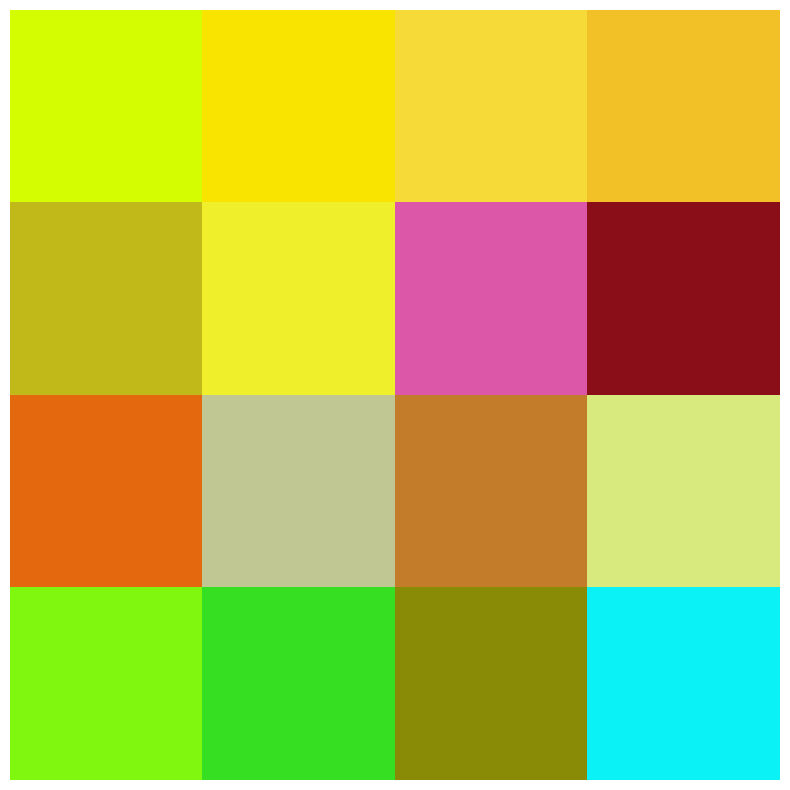

(None, torch.Size([1, 3, 4, 4]))

In [8]:
# TESTING G
g_in = torch.randn((1, 128, 1, 1), device=device)
g_out = g(g_in, alpha=0.5, layer_num=1)
show_images(g_out), g_out.shape

In [9]:
class Discriminator(nn.Module):
    def __init__(self, out_c=128):
        super().__init__()
        
        self.blocks = nn.ModuleList([
            D_ConvBlock(out_c//4, out_c//4, 3, 1),
            D_ConvBlock(out_c//4, out_c//2, 3, 1),
            D_ConvBlock(out_c//2, out_c, 3, 1),
            D_ConvBlock(out_c, out_c, 3, 1),
            D_ConvBlock(out_c, out_c, 3, 1),
            D_ConvBlock(out_c, out_c, 3, 1),
            D_ConvBlock(out_c+1, out_c, 3, 1, 4, 0, mbatch=True),
        ])
        
        self.from_rgb = nn.ModuleList([
            EqualLRConv2d(3, out_c//4, 1),
            EqualLRConv2d(3, out_c//4, 1),
            EqualLRConv2d(3, out_c//2, 1),
            EqualLRConv2d(3, out_c, 1),
            EqualLRConv2d(3, out_c, 1),
            EqualLRConv2d(3, out_c, 1),
            EqualLRConv2d(3, out_c, 1),
        ])
        
        self.num_layers = len(self.blocks)
        
        self.linear = EqualLRLinear(out_c, 1)
    
    def forward(self, x, layer_num, alpha):
        for i in reversed(range(layer_num)):
            idx = self.num_layers - i - 1
            #print(x.shape)
            if i+1 == layer_num:
                out = self.from_rgb[idx](x)
                #print()
            out = self.blocks[idx](out)
            
            if i > 0:
                out = F.interpolate(out, scale_factor=0.5, mode='bilinear')
                
                if i+1 == layer_num and 0 <= alpha < 1:
                    #skip = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)
                    skip = F.interpolate(x, scale_factor=0.5, mode='bilinear')
                    skip = self.from_rgb[idx + 1](skip)
                    out = (1 - alpha) * skip + alpha * out
        
        #out = out.squeeze(2).squeeze(2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

d = Discriminator().to(device)

In [10]:
d_in = torch.randn((1, 3, 32, 32), device=device)
d_out = d(d_in, alpha=0.5, layer_num=4)
d_out, d_out.shape

(tensor([[0.1139]], device='cuda:0', grad_fn=<AddmmBackward0>),
 torch.Size([1, 1]))

Training loop
from: https://github.com/odegeasslbc/Progressive-GAN-pytorch/blob/master/train.py

In [11]:
def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(1 - decay, par2[k].data)

In [12]:
batch_size = 16
def get_dataloader(image_size, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize images to the required size
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = ImageFolder(root='./celeba_hq_256', transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

    return dataloader
test_dataloader = get_dataloader

def imagefolder_loader(path):
    def loader(transform):
        data = datasets.ImageFolder(path, transform=transform)
        data_loader = DataLoader(data, shuffle=True, batch_size=batch_size,
                                 num_workers=4)
        return data_loader
    return loader

def sample_data(dataloader, img_size=4):
    transform = transforms.Compose([
        transforms.Resize(img_size+int(img_size*0.2)+1),  # Resize images to the required size
        transforms.RandomCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    loader = dataloader(transform)
    
    return loader
    

In [13]:
def train(g, d, init_layer_num, loader, total_iter=600000, checkpoint_dir='./checkpoints', sample_dir='./samples', resume_checkpoint=None):
    # Dynamically create new checkpoint dir with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_dir = os.path.join(checkpoint_dir, f"checkpoint_{timestamp}")
    sample_dir = os.path.join(sample_dir, f"sample_{timestamp}")
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)
    
    img_size = [4, 8, 16, 32, 64, 128, 256]
    
    layer_num = init_layer_num
    start_iter = 0
    
    # Resume from checkpoint if provided
    if resume_checkpoint and os.path.isfile(resume_checkpoint):
        print(f"Loading checkpoint from {resume_checkpoint}")
        checkpoint = torch.load(resume_checkpoint)
        g.load_state_dict(checkpoint['g_state_dict'])
        d.load_state_dict(checkpoint['d_state_dict'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
        layer_num = checkpoint['layer_num']
        start_iter = checkpoint['iteration'] + 1
        print(f"Resuming from layer {layer_num}, iteration {start_iter}")
    
    data_loader = sample_data(loader, img_size[layer_num-1])
    dataset = iter(data_loader)
    
    # may need to set total_iter//6 to //7?
    total_iter_remain = total_iter - (total_iter//7)*(layer_num-1)
    
    pbar = tqdm(range(total_iter_remain))
    
    disc_loss_val = 0
    gen_loss_val = 0
    grad_loss_val = 0
    
    alpha = 0
    one = torch.tensor(1, dtype=torch.float).to(device)
    mone = one * -1
    iteration = 0
    
    # Set up logging in the new checkpoint directory
    log_file = os.path.join(checkpoint_dir, 'training.log')
    logging.basicConfig(filename=log_file, level=logging.INFO, 
                        format='%(asctime)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')
    
    logging.info(f"Starting training session. Checkpoint directory: {checkpoint_dir}")

    # Initialize lists to store loss values for statistics
    disc_loss_history = []
    gen_loss_history = []
    grad_loss_history = []
    
    for i in pbar:
        try:
            d.zero_grad()

            alpha = min(1, (2/(total_iter//7)) * iteration)

            if iteration > total_iter//7:
                #print(f"Before transition - Layer: {layer_num}, Alpha: {alpha}, Iteration: {iteration}")
                alpha = 0
                iteration = 0
                layer_num += 1

                if layer_num > 7:
                    alpha = 1
                    layer_num = 7
                data_loader = sample_data(loader, img_size[layer_num-1])
                dataset = iter(data_loader)
                #print(f"After transition - New Layer: {layer_num}, Alpha: {alpha}, Iteration: {iteration}")
                # Save checkpoint at transition
                torch.save({
                    'g_state_dict': g.state_dict(),
                    'd_state_dict': d.state_dict(),
                    'g_optimizer_state_dict': g_optimizer.state_dict(),
                    'd_optimizer_state_dict': d_optimizer.state_dict(),
                    'layer_num': layer_num,
                    'iteration': i
                }, f'{checkpoint_dir}/transition_layer_{layer_num}_iter_{i}.pth')

            try:
                real_img, label = next(dataset)
            except (OSError, StopIteration):
                dataset = iter(data_loader)
                real_img, label = next(dataset)

            iteration += 1

            # Train D
            b_size = real_img.size(0)
            real_img = real_img.to(device)
            label = label.to(device)
            real_pred = d(real_img, layer_num=layer_num, alpha=alpha)
            real_pred = real_pred.mean() - 0.001 * (real_pred**2).mean()
            real_pred.backward(mone)

            # sample input data for g
            gen_z = torch.randn(b_size, 128).to(device)

            fake_img = g(gen_z, layer_num=layer_num, alpha=alpha)
            
            #print(f"Fake image stats - Min: {fake_img.min()}, Max: {fake_img.max()}, Mean: {fake_img.mean()}")
            #print(f"Real image stats - Min: {real_img.min()}, Max: {real_img.max()}, Mean: {real_img.mean()}")
            
            fake_pred = d(fake_img.detach(), layer_num=layer_num, alpha=alpha)
            fake_pred = fake_pred.mean()
            fake_pred.backward(one)
            
            #d_grad_norm = torch.nn.utils.clip_grad_norm_(d.parameters(), float('inf'))
            
            #print(f"D(real) stats - Min: {real_pred.min()}, Max: {real_pred.max()}, Mean: {real_pred.mean()}")
            #print(f"D(fake) stats - Min: {fake_pred.min()}, Max: {fake_pred.max()}, Mean: {fake_pred.mean()}")
            
            # Grad penalty for D
            eps = torch.rand(b_size, 1, 1, 1).to(device)
            x_hat = eps * real_img.data + (1 - eps) * fake_img.detach().data
            x_hat.requires_grad = True
            hat_predict = d(x_hat, layer_num=layer_num, alpha=alpha)
            grad_x_hat = grad(
                outputs=hat_predict.sum(), inputs=x_hat, create_graph=True)[0]
            grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1)
                             .norm(2, dim=1) - 1)**2).mean()
            grad_penalty = 10 * grad_penalty
            grad_penalty.backward()
            grad_loss_val += grad_penalty.item()
            disc_loss_val += (real_pred - fake_pred).item()
            
            # After computing losses and before optimizer steps
            #print(f"Iteration {i+1}, Layer {layer_num} - D Loss: {disc_loss_val}, Grad Penalty: {grad_loss_val}")
            d_optimizer.step()

            if (i+1) % n_critic == 0:
                g.zero_grad()
                d.zero_grad()

                pred = d(fake_img, layer_num=layer_num, alpha=alpha)

                loss = -pred.mean()
                gen_loss_val += loss.item()

                loss.backward()
                #print(f'LOSS: {loss}')
                #torch.nn.utils.clip_grad_norm_(g.parameters(), max_norm=1.0)
                #g_grad_norm = torch.nn.utils.clip_grad_norm_(g.parameters(), float('inf'))
                #print(f"Gradient norms - D: {d_grad_norm}, G: {g_grad_norm}")
                # After computing losses and before optimizer steps
                #print(f"Iteration {i+1}, Layer {layer_num} - G Loss: {gen_loss_val}")
                #g_grad_norm = torch.nn.utils.clip_grad_norm_(g.parameters(), max_norm=0.5)
                #print(f"Gradient norm  after clip, G: {g_grad_norm}")
                #for name, param in g.named_parameters():
                #    if torch.isnan(param).any():
                #        print(f"BEFORE OPTIM NaN detected in generator parameter: {name}")
                g_optimizer.step()
                accumulate(g_running, g)
                #for name, param in g.named_parameters():
                #    if torch.isnan(param).any():
                #        print(f"NaN detected in generator parameter: {name}")

            # Check for NaN values after each iteration
            if np.isnan(disc_loss_val) or np.isnan(gen_loss_val) or np.isnan(grad_loss_val):
                logging.error(f"NaN detected at iteration {i+1}")
                logging.error(f"Disc Loss: {disc_loss_val}, Gen Loss: {gen_loss_val}, Grad Loss: {grad_loss_val}")
                logging.error(f"Current layer: {layer_num}, Alpha: {alpha}")

                # Save final checkpoint before halting
                torch.save({
                    'g_state_dict': g.state_dict(),
                    'd_state_dict': d.state_dict(),
                    'g_optimizer_state_dict': g_optimizer.state_dict(),
                    'd_optimizer_state_dict': d_optimizer.state_dict(),
                    'layer_num': layer_num,
                    'iteration': i
                }, f'{checkpoint_dir}/nan_error_checkpoint_layer_{layer_num}_iter_{i+1}.pth')

                print("NaN values detected. Training halted. Check the log file for details.")
                return

            # Append loss values to history
            disc_loss_history.append(disc_loss_val)
            gen_loss_history.append(gen_loss_val)
            grad_loss_history.append(grad_loss_val)

            if (i+1)%500 == 0:
                state_msg = (f'{i + 1}; G: {gen_loss_val/(500//n_critic):.3f}; D: {disc_loss_val/500:.3f};'
                    f' Grad: {grad_loss_val/500:.3f}; Alpha: {alpha:.3f}')

                 # Calculate and log statistics
                avg_disc_loss = np.mean(disc_loss_history[-500:])
                avg_gen_loss = np.mean(gen_loss_history[-500//n_critic:])
                avg_grad_loss = np.mean(grad_loss_history[-500:])
                
                logging.info(state_msg)
                logging.info(f"Avg Disc Loss: {avg_disc_loss:.3f}, Avg Gen Loss: {avg_gen_loss:.3f}, Avg Grad Loss: {avg_grad_loss:.3f}")
                
                disc_loss_val = 0
                gen_loss_val = 0
                grad_loss_val = 0

                #print(state_msg)
                pbar.set_description(state_msg)

                with torch.no_grad():
                    sample_z = torch.randn(4, 128).to(device)
                    sample_imgs = g(sample_z, layer_num=layer_num, alpha=alpha)
                    save_image(sample_imgs, f'{sample_dir}/sample_layer_{layer_num}_iter_{i+1}.png', nrow=4, normalize=True)
                    show_images(sample_imgs)

            # Save checkpoint every 10000 iterations
            if (i+1) % 10000 == 0:
                torch.save({
                    'g_state_dict': g.state_dict(),
                    'd_state_dict': d.state_dict(),
                    'g_optimizer_state_dict': g_optimizer.state_dict(),
                    'd_optimizer_state_dict': d_optimizer.state_dict(),
                    'layer_num': layer_num,
                    'iteration': i
                }, f'{checkpoint_dir}/checkpoint_layer_{layer_num}_iter_{i+1}.pth')
        
            #print(f'Completed Iteration: {iteration}, Overall Iteration: {i+1}, Layer: {layer_num}, Alpha: {alpha:.3f}\n')
        except Exception as e:
            logging.error(f"Error occurred at iteration {i+1}: {str(e)}")
            raise

    # Log final statistics
    logging.info("Training completed.")
    logging.info(f"Final layer: {layer_num}, Total iterations: {i+1}")
    logging.info(f"Avg Disc Loss (last 1000): {np.mean(disc_loss_history[-1000:]):.3f}")
    logging.info(f"Avg Gen Loss (last 1000): {np.mean(gen_loss_history[-1000:]):.3f}")
    logging.info(f"Avg Grad Loss (last 1000): {np.mean(grad_loss_history[-1000:]):.3f}")

In [ ]:
class Args:
    def __init__(self):
        self.path = '/home/yusuf/python/YMPaperImplementations/paper_implementations/GANs_for_seaturtle_image_gen/celeba_hq_256'
        self.trial_name = "test1"
        self.gpu_id = 0
        self.lr = 0.001
        self.z_dim = 128
        self.channel = 128
        self.batch_size = 4
        self.n_critic = 1
        self.init_step = 1
        self.total_iter = 700000
        self.pixel_norm = False
        self.tanh = False

args = Args()

trial_name = args.trial_name
input_code_size = args.z_dim
batch_size = args.batch_size
n_critic = args.n_critic

generator = Generator().to(device)
discriminator = Discriminator().to(device)
g_running = Generator().to(device)

g_running.train(False)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=args.lr, betas=(0.0, 0.99))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=args.lr, betas=(0.0, 0.99))

accumulate(g_running, generator, 0)

loader = imagefolder_loader(args.path)

#train(generator, discriminator, args.init_step, loader, args.total_iter, resume_checkpoint='./checkpoints/checkpoint_20240713_000009/transition_layer_4_iter_128574.pth')
train(generator, discriminator, args.init_step, loader, args.total_iter)


## What now?
    - Run with 256 latents
    - Check why my EqualLR was bad
    - Check if it was the same issue in previous code i had (i.e. was the model okay the LR the problem)
    - Implement logging, saving checkpoints

In [ ]:
# Lets try with seaturtles!
class Args:
    def __init__(self):
        self.path = '/home/yusuf/python/YMPaperImplementations/paper_implementations/GANs_for_seaturtle_image_gen/images'
        self.trial_name = "test1"
        self.gpu_id = 0
        self.lr = 0.001
        self.z_dim = 128
        self.channel = 128
        self.batch_size = 4
        self.n_critic = 1
        self.init_step = 1
        self.total_iter = 700000
        self.pixel_norm = False
        self.tanh = False

args = Args()

trial_name = args.trial_name
input_code_size = args.z_dim
batch_size = args.batch_size
n_critic = args.n_critic

generator = Generator().to(device)
discriminator = Discriminator().to(device)
g_running = Generator().to(device)

g_running.train(False)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=args.lr, betas=(0.0, 0.99))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=args.lr, betas=(0.0, 0.99))

accumulate(g_running, generator, 0)

loader = imagefolder_loader(args.path)

#train(generator, discriminator, args.init_step, loader, args.total_iter, resume_checkpoint='./checkpoints/checkpoint_20240714_232605/checkpoint_layer_4_iter_260000.pth')
train(generator, discriminator, args.init_step, loader, args.total_iter)


## Next steps for seaturtle gen
    - Gen images with the left side flipped (makes them all right
    side images)
    - Remove the bad images from dataset
    - Increase dim of images